## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from scipy.interpolate import splrep
from scipy.interpolate import splev
from patsy.builtins import bs

## Clear the data 

After running this part of the code, we can work with the data from file: ```WISDM_ar_v1.1_raw_cleared.txt```.

In [4]:
f_read = open("../data/WISDM/WISDM_ar_v1.1_raw.txt", "r")
f_write = open("../data/WISDM/WISDM_ar_v1.1_raw_cleared.txt", "w")
for string in f_read.readlines():
    if string[-1] == '\n':
        string = string[:-1]
    if len(string) > 0:
        string_list = string.split(';')
        if len(string_list) > 2:
            for row in string_list[:2]:
                words = row.split(',')
                if len(words) > 5:
                    if len(words[5]) > 0:
                        f_write.write("%s,%s,%s,%s,%s,%s\n" % (words[0], words[1], 
                                                               words[2], words[3], 
                                                               words[4], words[5]))
        else:
            words = string_list[0].split(',')
            if len(words) > 5:
                if len(words[5]) > 0:
                    f_write.write("%s,%s,%s,%s,%s,%s\n" % (words[0], words[1], 
                                                           words[2], words[3], 
                                                           words[4], words[5]))
f_read.close()
f_write.close()

## Read data

Read the data to pandas:  
* ```id_user``` - identification number of the user (from 1 to 36 inclusively);
* ```activity``` - type of activity (our classes: ```['Downstairs', 'Sitting', 'Walking', 'Upstairs', 'Jogging', 'Standing']```);
* ```timestamp``` - time of measurement (in nanoseconds);
* ```x``` - acceleration in $x$ direction;
* ```y``` - acceleration in $y$ direction;
* ```z``` - acceleration in $z$ direction;

In [3]:
data = pd.read_table("../data/WISDM/WISDM_ar_v1.1_raw_cleared.txt", delimiter=',', header=None)
data.columns = ['id_user', 'activity', 'timestamp', 'x', 'y', 'z']
data.head()

,id_user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


Class distribution:

In [4]:
classes = list(set(data['activity']))
for activity in classes:
    nb = np.sum(data['activity'] == activity)
    print("{:<15}{:<9d}{:<5.2f} %".format(activity, nb, 100. * nb / data.shape[0]))
print()
print("Number of objects: {:d}".format(data.shape[0]))

Jogging        342179   31.16 %
Sitting        59939    5.46  %
Standing       48395    4.41  %
Walking        424399   38.64 %
Upstairs       122869   11.19 %
Downstairs     100427   9.14  %

Number of objects: 1098208


Example of the data:

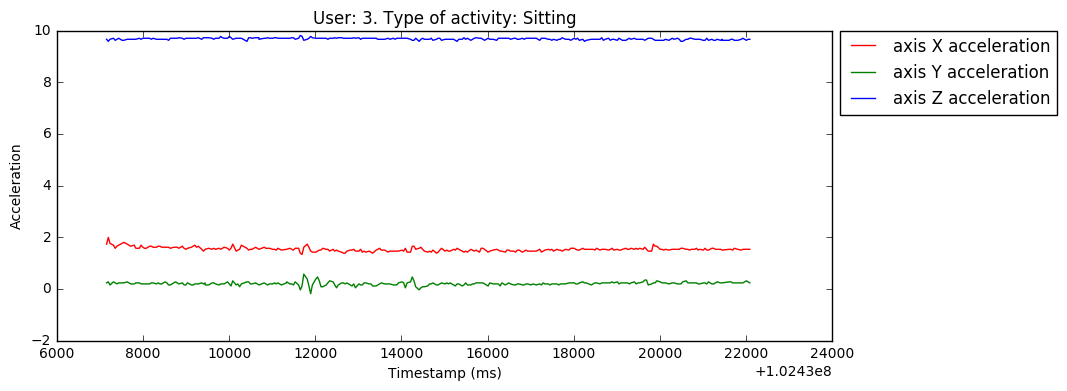

In [5]:
id_user, activity = 3, 'Sitting'

mask = (data.loc[:, 'id_user'] == id_user) & (data.loc[:, 'activity'] == activity)
x = np.array(data.loc[mask, 'timestamp'])[:np.min([300, np.sum(mask)])] / 10**6
yx = np.array(data.loc[mask, 'x'])[:np.min([300, np.sum(mask)])]
yy = np.array(data.loc[mask, 'y'])[:np.min([300, np.sum(mask)])]
yz = np.array(data.loc[mask, 'z'])[:np.min([300, np.sum(mask)])]

if np.sum(mask) > 0:
    plt.figure(figsize=(10, 4))
    plt.plot(x, yx, 'r', label='axis X acceleration')
    plt.plot(x, yy, 'g', label='axis Y acceleration')
    plt.plot(x, yz, 'b', label='axis Z acceleration')
    plt.xlabel('Timestamp (ms)')
    plt.ylabel('Acceleration')
    plt.title("User: {}. Type of activity: {}".format(id_user, activity))
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.show()
else:
    print("There is no such data.")

## Base method

The idea is the following: we will consider 10 seconds time series (or 200 points of measurements) and calculate 40 features:
* ```[3]``` - mean acceleration of each axis;
* ```[3]``` - std of acceleration of each axis;
* ```[3]``` - mean absolute deviation of acceleration of each axis;
* ```[1]``` - mean acceleration;
* ```[30]``` - distribution of time series values of each axis. First of all we calculate min and max of each component ($X, Y, Z$) from the whole interval. Then we divide the range of values of each component into 10 equal intervals and calculate on each each interval the percent of values that are in it (in the corresponding interval).  

And apply LogisticRegression and SVM.

### Creating object-feature matrix

So we need to construct 10 seconds time series. To do it we need to remember the following:
* each time series should be from one user and one type of activity;
* in the time series timestamp should't differ more than 0.2 second (empirical rule, in ideal all timestamp should differ on 50 ms = 0.05 second).

Now let's create **object-feature** matrix:

In [6]:
def check_candidat(candidat, threshold=2.*1e8):
    tsp = np.array(candidat['timestamp'])
    diffs = tsp[1:] - tsp[:-1]
    
    return np.sum(diffs > threshold) == 0

def get_time_series(accelerations, nb=200):
    accelerations.index = [i for i in range(len(accelerations))]
    TS = []
    st = 0
    fi = st + nb
    while fi < len(accelerations):
        candidat = accelerations.loc[[st + i for i in range(nb)], :]
        if check_candidat(candidat):
            TS.append([np.array(candidat['x']), 
                       np.array(candidat['y']), 
                       np.array(candidat['z'])])
        st = fi
        fi += nb
    
    return TS

def get_features(ts):
    x = ts[0]
    y = ts[1]
    z = ts[2]
    n = x.shape[0]
    features = []
    features.append(x.mean())
    features.append(y.mean())
    features.append(z.mean())
    features.append(x.std())
    features.append(y.std())
    features.append(z.std())
    features.append(np.abs(x - x.mean()).mean())
    features.append(np.abs(y - y.mean()).mean())
    features.append(np.abs(z - z.mean()).mean())
    features.append((x+y+z).mean() / 3.)
    x_range = np.linspace(x.min(), x.max(), 11)
    y_range = np.linspace(y.min(), y.max(), 11)
    z_range = np.linspace(z.min(), z.max(), 11)
    for i in range(10):
        features.append(1. * np.sum((x_range[i] <= x) & (x < x_range[i+1])) / n)
        features.append(1. * np.sum((y_range[i] <= y) & (y < y_range[i+1])) / n)
        features.append(1. * np.sum((z_range[i] <= z) & (z < z_range[i+1])) / n)
    
    return features

def get_spline_features(ts, fraction=0.4):
    x = ts[0]
    y = ts[1]
    z = ts[2]
    nb = len(x)
    t = list(range(nb))
    knots = np.linspace(t[0], t[nb-1], endpoint=False, num=int(fraction*nb))[1:]
    spl_x = splrep(t, x, task=-1, t=knots)
#     tx = np.linspace(1, 200, 1000)
#     xx = splev(tx, spl_x)
#     plt.plot(t, x)
#     plt.plot(tx, xx, c='r')
#     plt.ylim(-10, 10)
    spl_y = splrep(t, y, task=-1, t=knots)
    spl_z = splrep(t, z, task=-1, t=knots)
    #print(len(spl_x[1]))
    return np.concatenate((spl_x[1], spl_y[1], spl_z[1]), axis=0)

In [7]:
id_range = np.unique(np.array(data['id_user']))
features = []
act = []
for id_user in id_range:
    for activity in classes:
        mask = (data.loc[:, 'id_user'] == id_user) & (data.loc[:, 'activity'] == activity)
        accelerations = data.loc[mask, ['timestamp', 'x', 'y', 'z']].copy()
        TS = get_time_series(accelerations, nb=200)
        for ts in TS:
            features.append(get_spline_features(ts))
            act.append(classes.index(activity))
X = np.array(features)
y = np.array(act)

Class distribution:

In [10]:
for activity in classes:
    nb = np.sum(y == classes.index(activity))
    print("{:<15}{:<9d}{:<5.2f} %".format(activity, nb, 100. * nb / len(y)))
print()
print("Number of objects: {:d}".format(len(y)))

Jogging        1075     24.88 %
Sitting        277      6.41  %
Standing       229      5.30  %
Walking        1917     44.36 %
Upstairs       466      10.78 %
Downstairs     357      8.26  %

Number of objects: 4321


### Classification

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Let's try LogisticRegression:

In [47]:
def get_internal_score(clf, X, y, max_iter=50):
    nb = np.unique(y).shape[0]
    scores = np.zeros(nb+1)
    for j in range(max_iter):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        scores[0] += accuracy_score(y_test, y_predict)
        for i in range(nb):
            scores[i+1] += accuracy_score(1*(np.array(y_test) == i), 
                                         1*(np.array(y_predict) == i))
            
    return scores / max_iter

In [48]:
parameters = {'penalty': ['l1', 'l2'], 
              'class_weight': ['balanced', None], 
              'C': 10. ** np.arange(0, 5, 1)}
clf = LogisticRegression()
clf = GridSearchCV(clf, parameters)
clf.fit(X_train, list(y_train))
clf_lr = clf.best_estimator_
scores = get_internal_score(clf_lr, X, list(y))

In [49]:
print("{:<20}{:<7}{:<11}{:<11}{:<11}{:<11}{:<11}{:<11}".format("", "all", *classes))
print("{:<20}{:<7.3f}{:<11.3f}{:<11.3f}{:<11.3f}{:<11.3f}{:<11.3f}{:<11.3f}".format("LogisticRegression:", *scores))

                    all    Sitting    Jogging    Standing   Downstairs Upstairs   Walking    
LogisticRegression: 0.567  0.984      0.785      0.946      0.900      0.875      0.645      
